Defaulting to user installation because normal site-packages is not writeable
Found annotations at 'C:\Users\646ca\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-18000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │          20,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,716,928 (14.18 MB)

 Trainable params: 3,716,928 (14.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 229s 279ms/step - binary_accuracy: 0.9601 - loss: 0.1478 - val_binary_accuracy: 0.9659 - val_loss: 0.1224
Epoch 2/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 194s 245ms/step - binary_accuracy: 0.9655 - loss: 0.1217 - val_binary_accuracy: 0.9661 - val_loss: 0.1202
Epoch 3/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 212s 258ms/step - binary_accuracy: 0.9667 - loss: 0.1109 - val_binary_accuracy: 0.9651 - val_loss: 0.1300
Epoch 4/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 186s 236ms/step - binary_accuracy: 0.9697 - loss: 0.0935 - val_binary_accuracy: 0.9620 - val_loss: 0.1582
Epoch 5/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 197s 250ms/step - binary_accuracy: 0.9755 - loss: 0.0720 - val_binary_accuracy: 0.9598 - val_loss: 0.2111
Epoch 6/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 201s 255ms/step - binary_accuracy: 0.9808 - loss: 0.0542 - val_binary_accuracy: 0.9565 - val_loss: 0.2472
Epoch 7/20
788/788 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - binary_accuracy: 0.9851 - loss: 0.0411 - val_binary_accuracy: 0.95

Model saved to models/coco80_cnn.h5


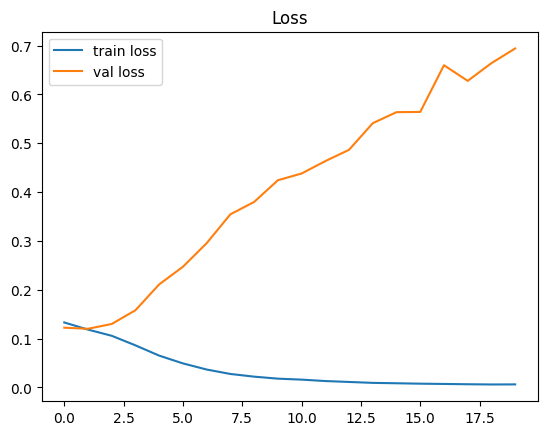

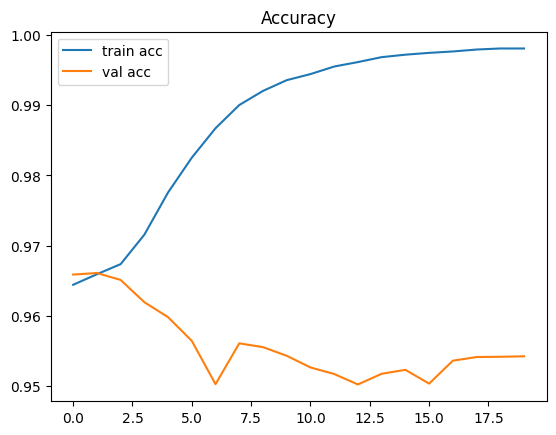

In [ ]:
# # COCO-2017 80-Category Image Classifier
# 
# A from-scratch CNN for multi-label classification on COCO-2017.

# Install packages
!pip install fiftyone tensorflow numpy matplotlib pillow opencv-python

import random
import fiftyone.zoo as foz
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard

# How many COCO samples to load (None = all ~82k)
MAX_SAMPLES = 18000

# Training hyperparams
BATCH_SIZE = 16
EPOCHS     = 20
IMG_SIZE   = (256, 256)

# For reproducibility
random.seed(42)
tf.random.set_seed(42)

# %% [markdown]
# 1) Load COCO-2017 training split via FiftyOne
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    max_samples=MAX_SAMPLES
)

# 2) Shuffle & split into train / val / test
samples = list(dataset)
random.shuffle(samples)
n = len(samples)
n_train = int(0.7 * n)
n_val   = int(0.2 * n)

train_samples = samples[:n_train]
val_samples   = samples[n_train:n_train + n_val]
test_samples  = samples[n_train + n_val:]

# %% [markdown]
# ## Build class map & tf.data pipelines

# %% [code]
# COCO has 80 classes
class_list   = dataset.default_classes
num_classes  = len(class_list)
class_to_idx = {c: i for i, c in enumerate(class_list)}

def sample_to_path_label(sample):
    path = sample.filepath
    lbl  = np.zeros(num_classes, dtype=np.int32)
    # some samples have no ground_truth – guard against None
    dets = getattr(sample.ground_truth, "detections", None)
    if dets:
        for det in dets:
            lbl[class_to_idx[det.label]] = 1
    return path, lbl

# Gather paths & labels
train_paths, train_labels = zip(*(sample_to_path_label(s) for s in train_samples))
val_paths,   val_labels   = zip(*(sample_to_path_label(s) for s in val_samples))
test_paths,  test_labels  = zip(*(sample_to_path_label(s) for s in test_samples))

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((list(paths), list(labels)))
    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label
    return ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE) \
             .batch(BATCH_SIZE) \
             .prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(train_paths, train_labels)
val_ds   = make_ds(val_paths,   val_labels)
test_ds  = make_ds(test_paths,  test_labels)

# %% [markdown]
# ## Define the CNN model (from scratch)

# %% [code]
model = Sequential([
    Input(shape=(*IMG_SIZE, 3)),
    # Conv block 1
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),
    # Conv block 2
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    # Conv block 3
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(),
    # Classifier head
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='sigmoid')   # 80-way multi-label
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',     # multi-label
    metrics=['binary_accuracy']
)

model.summary()

# %% [markdown]
# ## Train

# %% [code]
logdir = 'logs'
tensorboard_cb = TensorBoard(log_dir=logdir)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[tensorboard_cb]
)

# %% [markdown]
# ## Plot training curves

# %% [code]
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.figure()
plt.plot(history.history['binary_accuracy'], label='train acc')
plt.plot(history.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

# %% [markdown]
# ## Evaluate on test set

# %% [code]
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# %% [markdown]
# ## Save the trained model

# %% [code]
os.makedirs('models', exist_ok=True)
model.save('models/coco80_cnn.h5')
print("Model saved to models/coco80_cnn.h5") # renamed modelPhase2.h5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


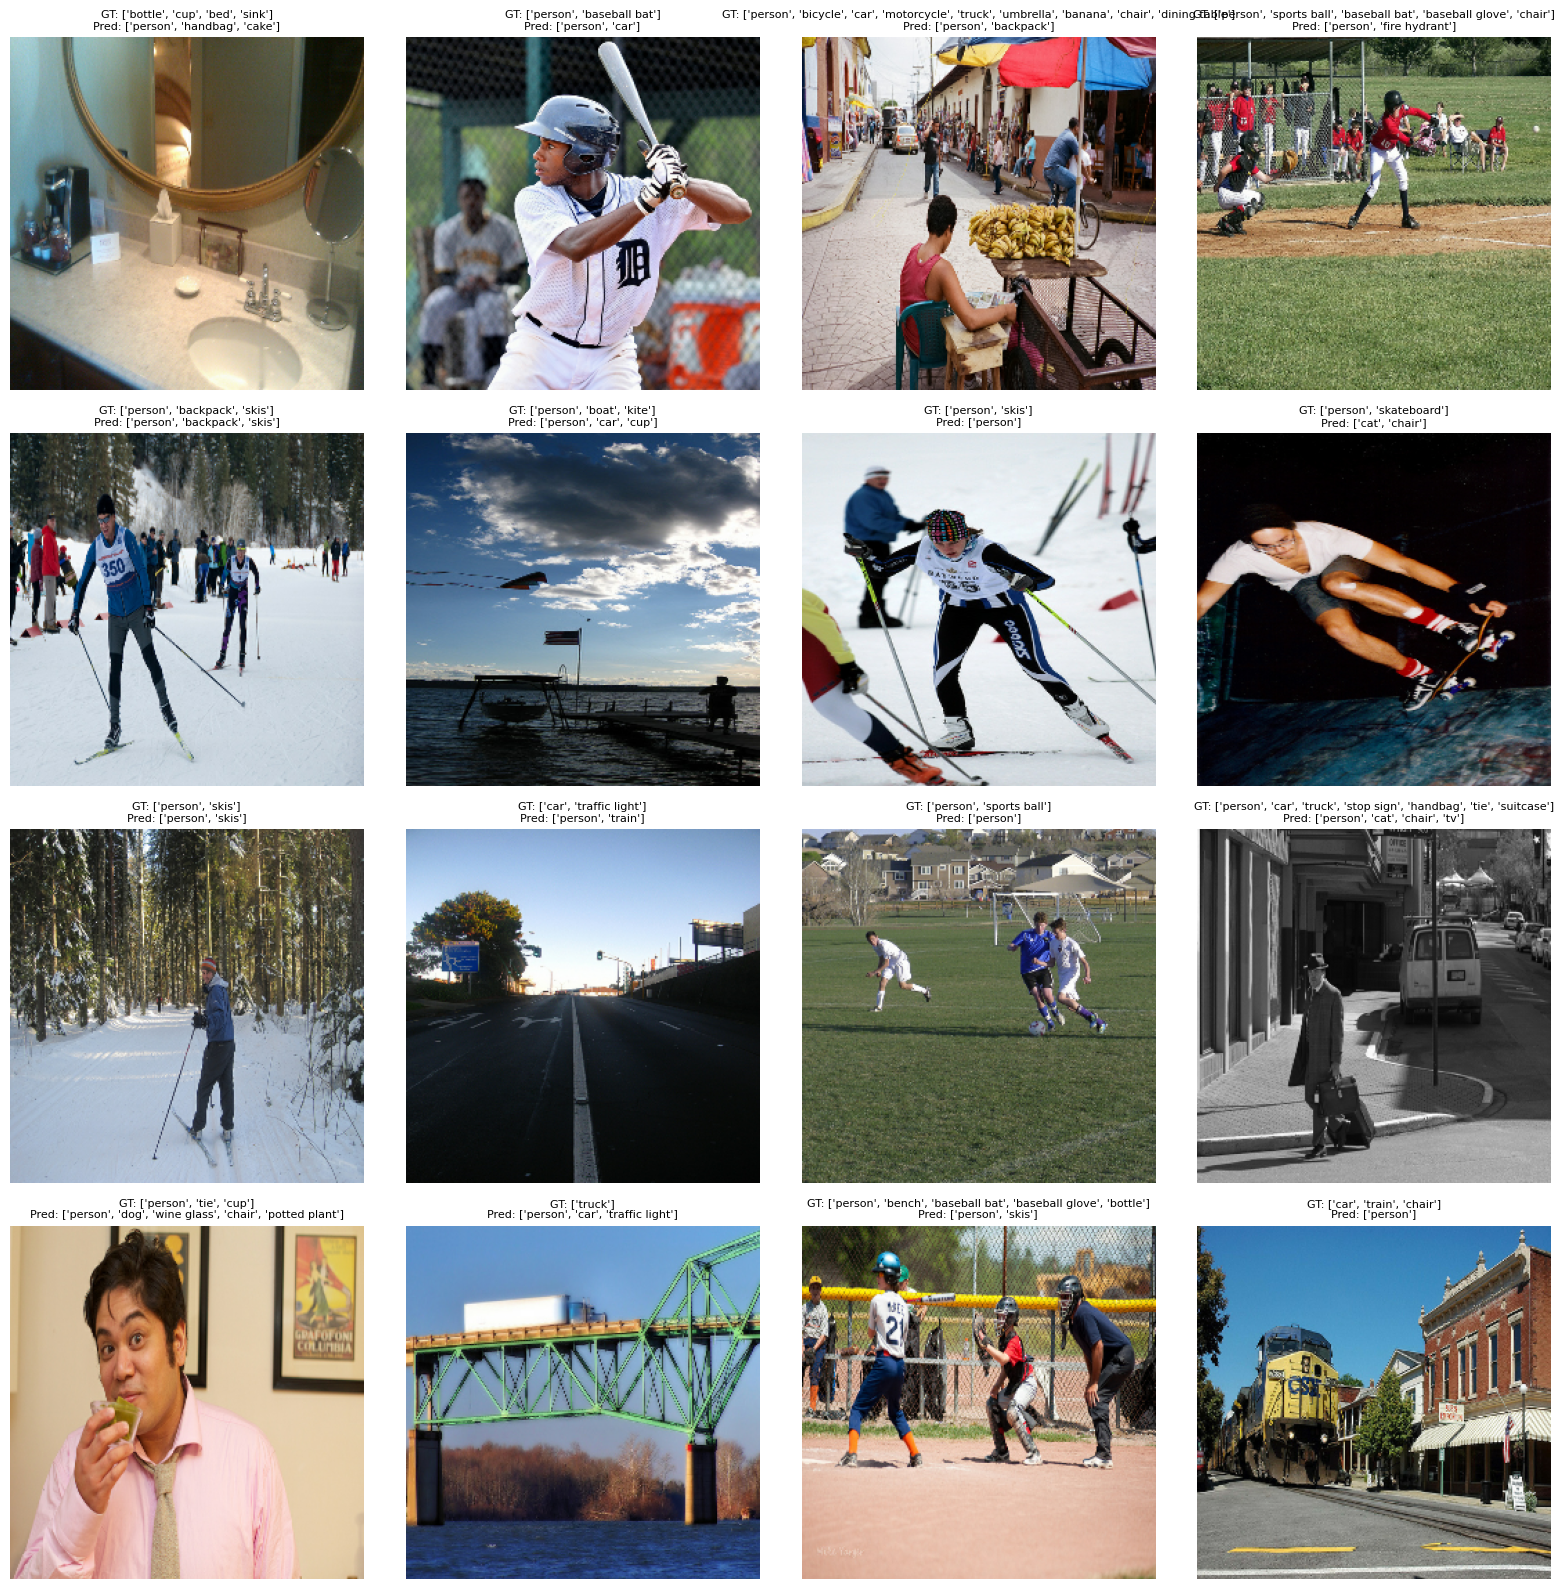

In [4]:
# %% [markdown]
# ## Test on Sample Images

# %% [code]
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 1) Load your saved model
model = load_model('models/coco80_cnn.h5')

# 2) Grab one batch from test_ds
for images, labels in test_ds.take(1):
    preds = model.predict(images)  # shape: (batch_size, 80)
    break

# 3) Visualize the first 16 images and their GT vs. predicted classes
fig, axes = plt.subplots(4, 4, figsize=(16,16))
axes = axes.flatten()
for img, true_lbl, pred_probs, ax in zip(images.numpy(), labels.numpy(), preds, axes):
    # ground-truth classes
    gt = [class_list[i] for i,v in enumerate(true_lbl) if v==1]
    # predicted classes (prob > 0.5)
    pred = [class_list[i] for i,p in enumerate(pred_probs) if p > 0.5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"GT: {gt}\nPred: {pred}", fontsize=8)
plt.tight_layout()

In [5]:
from PIL import Image
import numpy as np

def predict(img_path):
    try:
        img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
        arr = np.expand_dims(np.array(img)/255.0, 0)
        
        pred = model.predict(arr)[0]
        pred_classes = [class_list[i] for i,p in enumerate(pred) if p > 0.5]
        
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Pred: " + ", ".join(pred_classes), fontsize=10)
    except Exception as e:
        print({e})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


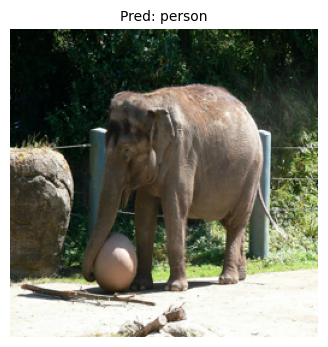

In [10]:
predict(r'C:\Users\646ca\Downloads\CPP Spring 2025\CPP-Spring2025-CS4200-FinalProject\test_img\elephant.jpg')